In [1]:
## Import Essential Libraries
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor
import matplotlib.pyplot as plt
import string
import scipy.io as sio
import scipy.linalg as slinalg
import torchvision
from torchvision import datasets, transforms
import glob
from scipy.io import savemat
from torch.autograd import Variable

In [2]:
# Define the Lidar CNN
class Lidar_CNN_Pose_Cov(nn.Module):
    def __init__(self):
        super(Lidar_CNN_Pose_Cov, self).__init__()

        # Define constants
        self.image_size = np.uint16([180, 360])
        self.num_fc_input = int(15840)
        self.out_pose_size = 3
        self.out_cov_size = 6
        self.out_diag_size = 3
        self.kernel_size = np.uint16([2,2])
        self.num_conv_layer = 3
        self.max_pool_stride = np.uint16([2, 2])

        # Define the convolutional layers
        self.en_conv1 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=[2, 2], stride=[1, 1])
        self.en_conv2 = nn.Conv2d(in_channels=self.en_conv1.out_channels, out_channels=self.en_conv1.out_channels * 2, kernel_size=[2, 2], stride=[1, 1])
        self.en_conv3 = nn.Conv2d(in_channels=self.en_conv2.out_channels, out_channels=self.en_conv2.out_channels * 2, kernel_size=[2, 2], stride=[1, 1])

        # Define the max pooling layer
        self.pool = nn.MaxPool2d(kernel_size = [1,1], stride=[2,2])

        # Define the fully connected layers
        self.fc1_pose = nn.Linear(self.num_fc_input, int(self.num_fc_input/2))
        self.fc2_pose = nn.Linear(self.fc1_pose.out_features, int(self.fc1_pose.out_features/2))
        self.fc3_pose = nn.Linear(self.fc2_pose.out_features, int(self.fc2_pose.out_features/2))
        self.fc4_pose = nn.Linear(self.fc3_pose.out_features, int(self.fc3_pose.out_features/2))

        self.fc1_cov = nn.Linear(self.num_fc_input, int(self.num_fc_input / 2))
        self.fc2_cov = nn.Linear(self.fc1_cov.out_features, int(self.fc1_cov.out_features / 2))
        self.fc3_cov = nn.Linear(self.fc2_cov.out_features, int(self.fc2_cov.out_features / 2))

        # Define the dropoout layer
        self.dropout = nn.Dropout(p = 0.05)

        # Define the position and attitude output layer
        # self.out_pose = nn.Linear(self.fc3_pose.out_features, self.out_pose_size)
        self.out_pose = nn.Linear(self.fc4_pose.out_features, self.out_pose_size)
        self.out_cov_l = nn.Linear(self.fc3_cov.out_features, self.out_cov_size)

        # Define the neural network structure
    def forward(self, x):
        # 1st convolution Layer and max pooling
        x = self.pool(self.en_conv1(x))
        # Save the first convolution image
        conv1_img = x

        # 2nd convolution Layer and max pooling
        x = self.pool(self.en_conv2(x))
        # Save the first convolution image
        conv2_img = x

        # 3rd convolution Layer and max pooling
        x = self.pool(self.en_conv3(x))
        # Save the first convolution image
        conv3_img = x

        # Flatten the convolution
        x = x.view(x.shape[0], np.prod(x.shape[1:]))

        # 1st Dropout Layer
        x_pose = self.dropout(x)
        x_cov  = self.dropout(x)
        # 1st Fully Connected Layer
        x_pose = F.relu(self.fc1_pose(x_pose))
        x_cov  = F.relu(self.fc1_cov(x_cov))

        # 2nd Dropout Layer
        x_pose = self.dropout(x_pose)
        x_cov  = self.dropout(x_cov)
        # 2nd Fully Connected Layer
        x_pose = F.relu(self.fc2_pose(x_pose))
        x_cov  = F.relu(self.fc2_cov(x_cov))

        # 3rd Dropout Layer
        x_pose = self.dropout(x_pose)
        x_cov  = self.dropout(x_cov)
        # 3rd Fully Connected Layer
        x_pose = F.relu(self.fc3_pose(x_pose))
        x_cov  = F.relu(self.fc3_cov(x_cov))

        # 4th Dropout Layer
        x_pose = self.dropout(x_pose)
        x_pose = F.relu(self.fc4_pose(x_pose))

        # Output Layer
        pose_pred = self.out_pose(x_pose)
        cov_pred  = self.out_cov_l(x_cov)
        return pose_pred, cov_pred

def pose_norm_loss(pose_pred, pose_target, cov_est, num_batch ):
    I = torch.eye(3)
    loss = 0

    for i in range(num_batch):
        pose_error = pose_target[:, i] - pose_pred[:, i]
        loss_j = torch.matmul(torch.matmul(pose_error, torch.linalg.inv(cov_est)), pose_error) / 10000 / num_batch

        # Add loss for each covariance estimation
        loss += loss_j

    # Return the loss
    return loss

def cov_cholesky_norm_loss(cov_mat_target, cov_mat_pred_L, num_batch ):
    I = torch.eye(3)
    loss = 0

    for i in range(num_batch):
        # Calculate the loss
        cov_target = cov_mat_target[i, :, :]
        L_target = torch.linalg.cholesky(cov_target)
        L_pred = cov_mat_pred_L[i, :, :]

        cov_pred = torch.matmul(L_pred, L_pred.T)
        cov_ratio = torch.matmul(torch.matmul(torch.linalg.inv(L_target.T), cov_pred), torch.linalg.inv(L_target))

        cov_pred_error = torch.matmul((I - cov_ratio), (I - cov_ratio).T)
        loss_j = 1/2 * torch.sqrt(torch.trace(cov_pred_error)) / 10000

        # Add loss for each covariance estimation
        loss += loss_j

    # Return the loss
    return loss



In [3]:
!export CUDA_VISIBLE_DEVICES=0
!export CUDA_LAUNCH_BLOCKING=1 

# Enable gpu processing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the LIDAR CNN
lidarCNNPoseCov = Lidar_CNN_Pose_Cov().to(device)
# lidarCNNPose    = Lidar_CNN_Pose().to(device)

# Define the loss function and optimizer
criterion       = nn.MSELoss()
criterion_pose  = nn.L1Loss()
criterion_cov   = nn.L1Loss()

train_cov = False
if (train_cov == True):
    lidarCNNPoseCov.load_state_dict(torch.load('./model/spherical/lidarCNN_Sph_Pose10000.pth'))

    # Freeze the convolutional layers
    lidarCNNPoseCov.en_conv1.weight.requires_grad = False
    lidarCNNPoseCov.en_conv1.bias.requires_grad = False
    lidarCNNPoseCov.en_conv2.weight.requires_grad = False
    lidarCNNPoseCov.en_conv2.bias.requires_grad = False
    lidarCNNPoseCov.en_conv3.weight.requires_grad = False
    lidarCNNPoseCov.en_conv3.bias.requires_grad = False

    # Freeze the layers used to calculate the pose
    lidarCNNPoseCov.fc1_pose.weight.requires_grad = False
    lidarCNNPoseCov.fc1_pose.bias.requires_grad = False
    lidarCNNPoseCov.fc2_pose.weight.requires_grad = False
    lidarCNNPoseCov.fc2_pose.bias.requires_grad = False
    lidarCNNPoseCov.fc3_pose.weight.requires_grad = False
    lidarCNNPoseCov.fc3_pose.bias.requires_grad = False
    lidarCNNPoseCov.out_pose.weight.requires_grad = False
    lidarCNNPoseCov.out_pose.bias.requires_grad   = False

    # Unfreeze the layers used to calculate the covariance
    lidarCNNPoseCov.fc1_cov.weight.requires_grad = True
    lidarCNNPoseCov.fc1_cov.bias.requires_grad   = True
    lidarCNNPoseCov.fc2_cov.weight.requires_grad = True
    lidarCNNPoseCov.fc2_cov.bias.requires_grad   = True
    lidarCNNPoseCov.fc3_cov.weight.requires_grad = True
    lidarCNNPoseCov.fc3_cov.bias.requires_grad   = True
    lidarCNNPoseCov.out_cov_l.weight.requires_grad = True
    lidarCNNPoseCov.out_cov_l.bias.requires_grad   = True

else:
    # lidarCNNPoseCov.load_state_dict(torch.load('./model/lidarCNNPoseCov_AzEl_Mini_Pose_Trained_10000.pth'))
    # Freeze the layers used to calculate the covariance
    lidarCNNPoseCov.fc1_cov.weight.requires_grad = False
    lidarCNNPoseCov.fc1_cov.bias.requires_grad   = False
    lidarCNNPoseCov.fc2_cov.weight.requires_grad = False
    lidarCNNPoseCov.fc2_cov.bias.requires_grad   = False
    lidarCNNPoseCov.fc3_cov.weight.requires_grad = False
    lidarCNNPoseCov.fc3_cov.bias.requires_grad   = False
    lidarCNNPoseCov.out_cov_l.weight.requires_grad = False
    lidarCNNPoseCov.out_cov_l.bias.requires_grad   = False

In [4]:
device

device(type='cuda', index=0)

In [5]:
import json
import tifffile

# Lidar Point Cloud Regularization Factor
lidarRegFactor = 1000
RAD_TO_DEG = 180 / np.pi

# Azimuth Angle Regularization Factor
azRegFactor = 1

## Loading Data
# Load the Lidar Data Log
lidarJsonPath = './lidar_image_data.json'

with open(lidarJsonPath, 'r') as file:
    lidar_data = json.load(file)

num_train = 30
posVehInNavLog = []
azVehInNavLog = []
lidarSphereLog = []
for entries in lidar_data['entries']:
    loopNum = entries['loopNum']

    if (loopNum <= num_train):
        trajectoryStr = entries['trajectoryStr']
        trajectoryStr = trajectoryStr[:-4]
        posVehInNavTruth = entries['posVehInNavTruth']
        azVehInNavTruth = entries['azVehInNavTruth']
        posVehInNavLog.append(posVehInNavTruth)
        azVehInNavLog.append(azVehInNavTruth)

        # Read the TIF file
        image = tifffile.imread('./images/' + trajectoryStr + '/' + entries['imageName'])
        lidarSphereLog.append(image)
    else:
        break


# Tensorify our arrays
posVehInNavLog = torch.Tensor(np.array(posVehInNavLog) / lidarRegFactor)
azVehInNavLog  = torch.Tensor(np.array(azVehInNavLog))
lidarSphereLog = torch.Tensor(np.array(lidarSphereLog))

In [6]:
# Setup the optimizer and scheduler
optimizer = optim.SGD(lidarCNNPoseCov.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

alpha = 0.01
beta = 10
gamma = 1

# cov_est = torch.tensor([(10 / lidarRegFactor) ** 2, (10 / lidarRegFactor) ** 2, (1 / RAD_TO_DEG / azRegFactor) ** 2])
# cov_est = torch.diag(cov_est)

training_enable = 1
save_model = 1

In [7]:
import random

# Step 2: Arrange into batches
def create_batches(numbers, batch_size):
    """Split a list into batches of specified size"""
    return [numbers[i:i + batch_size] for i in range(0, len(numbers), batch_size)]


In [8]:
cov_est = torch.tensor([(10 / lidarRegFactor) ** 2, (10 / lidarRegFactor) ** 2, (1 / RAD_TO_DEG / azRegFactor) ** 2])
cov_est = torch.diag(cov_est)

numTrainImg = lidarSphereLog.shape[0]
batch_size = 16

## Training Section
if (training_enable == True):
    num_epoch = 10000

    for epoch in range(0,num_epoch+1):
        running_loss = 0

        unique_numbers = random.sample(range(numTrainImg), numTrainImg)  # Gets 10 unique numbers from 0-100

        batched_arrays = create_batches(unique_numbers, batch_size)

        for batch in batched_arrays:
            # Pull the input tensor
            input_tensor = lidarSphereLog[batch, :, :, :]
            # input_tensor = input_tensor.unsqueeze(1)

            # Pull the target tensors
            pose_target = torch.zeros([3,batch.__len__()])
            pose_target[0,:] = posVehInNavLog[batch,0]
            pose_target[1,:] = posVehInNavLog[batch,1]
            pose_target[2,:] = azVehInNavLog[batch]

            # Run the lidar image through the lidar CNN
            pose_pred, cov_pred = lidarCNNPoseCov(input_tensor.to(device))
            pose_pred = Tensor.cpu(pose_pred)
            cov_pred  = Tensor.cpu(cov_pred)

            pos_pred = pose_pred[:,0:2]
            att_pred = pose_pred[:, 2]

            # Concatenate the target
            # target = torch.cat((pos_target, att_target, cov_target), axis=1)

            # Compute the estimation loss
            # loss_pose = criterion_pose(pose_pred,pose_target)

            if (train_cov == True):
                
                cov_mat_target = covPoseInNavLog[:,img_idx,:,:]

                # Convert the covariance prediction into a matrix
                cov_mat_pred_L = torch.zeros(num_train, 3, 3)
                cov_mat_pred_D = torch.zeros(num_train, 3, 3)
                cov_mat_pred_L[:, 0, 0] = cov_pred[:, 0]
                cov_mat_pred_L[:, 1, 0] = cov_pred[:, 1]
                cov_mat_pred_L[:, 1, 1] = cov_pred[:, 2]
                cov_mat_pred_L[:, 2, 0] = cov_pred[:, 3]
                cov_mat_pred_L[:, 2, 1] = cov_pred[:, 4]
                cov_mat_pred_L[:, 2, 2] = cov_pred[:, 5]

                cov_mat_pred_D[:, 0, 0] = 1
                cov_mat_pred_D[:, 1, 1] = 1
                cov_mat_pred_D[:, 2, 2] = 1

                cov_mat_pred = torch.zeros(num_train, 3, 3)
                for i in range(num_train):
                    cov_mat_pred[i,:,:] = torch.matmul( torch.matmul(cov_mat_pred_L[i,:,:], cov_mat_pred_D[i,:,:]), cov_mat_pred_L[i,:,:].T.squeeze())

                loss = cov_cholesky_norm_loss(cov_mat_target, cov_mat_pred_L, batch_size)
            else:
                # loss = pose_norm_loss(pose_pred.T, pose_target, cov_est, batch.__len__())
                loss = criterion_pose(pose_pred.T, pose_target)

            loss.backward()

            # Optimize
            optimizer.step()
            optimizer.zero_grad()

            # Debugging
            running_loss += loss.item()
        # End of Iteration Loop

        # Break training if loss fall belows some threshold
        # if (epoch % 1000 == 0):
        #     scheduler.step()

        # Print Results
        if epoch % 1 == 0:
            print("Epoch: %d, loss: %1.10f" % (epoch, running_loss))
        if epoch % 1000 == 0:
            print('Saving model!')
            if (train_cov == False):
                file_name = 'lidarCNN_Sph_Pose' + str(epoch)
                torch.save(lidarCNNPoseCov.state_dict(), './models/spherical_pose/'+file_name+'.pth')
            else:
                file_name = 'lidarCNN_Sph_PoseCov' + str(epoch)
                torch.save(lidarCNNPoseCov.state_dict(), './models/spherical_cov/'+file_name+'.pth')

            # End of Save Model

    # Final Training Results
    print("Final Training Results: loss: %1.10f" % (running_loss/numTrainImg))

# End of Epoch Loop
else: # Training Enable False
    # Load the state dictionary
    lidarCNNPoseCov.load_state_dict(torch.load('./model/lidarCNNPoseCov_AzEl_Mini_Pose_Trained_10000.pth'))
    # lidarCNNPoseCov.load_state_dict(torch.load('./model/lidarCNNPoseCov_Pose_Trained.pth'))
# End of Training

/home/julian/miniconda3/envs/lidar-ml-py/lib/python3.9/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0, loss: 191.1873614788
Saving model!
Epoch: 1, loss: 113.6217882037
Epoch: 2, loss: 91.1301144063
Epoch: 3, loss: 77.8508609980
Epoch: 4, loss: 69.7369757891
Epoch: 5, loss: 64.7599072754
Epoch: 6, loss: 59.4648761004
Epoch: 7, loss: 55.9198963121
Epoch: 8, loss: 52.7970433906
Epoch: 9, loss: 50.6306385547
Epoch: 10, loss: 48.6517306268
Epoch: 11, loss: 47.3831598386
Epoch: 12, loss: 45.4797338694
Epoch: 13, loss: 44.4485431835
Epoch: 14, loss: 42.8758940995
Epoch: 15, loss: 42.0903080404
Epoch: 16, loss: 40.1399918795
Epoch: 17, loss: 39.8167101592
Epoch: 18, loss: 38.9333392009
Epoch: 19, loss: 38.1011901498
Epoch: 20, loss: 37.3581988066
Epoch: 21, loss: 36.3458500057
Epoch: 22, loss: 36.0117205605
Epoch: 23, loss: 35.3198554143
Epoch: 24, loss: 35.0465147346
Epoch: 25, loss: 34.1730712689
Epoch: 26, loss: 33.8792064078
Epoch: 27, loss: 32.8002846874
Epoch: 28, loss: 32.4330957942
Epoch: 29, loss: 32.1181829460
Epoch: 30, loss: 31.6369553953
Epoch: 31, loss: 31.4226352014
Ep

In [ ]:
lidarCNNPoseCov.load_state_dict(torch.load('./model/spherical/lidarCNN_Sph_Pose10000.pth'))

num_train = 30

sampleArray = []
poseArray = []

for entries in lidar_data['entries']:
    loopNum = entries['loopNum']

    if (loopNum <= num_train):
        trajectoryStr = entries['trajectoryStr']
        trajectoryStr = trajectoryStr[:-4]
        posVehInNavTruth = entries['posVehInNavTruth']
        azVehInNavTruth = entries['azVehInNavTruth']
        sampleNum = entries['sampleNum']

        # Read the TIF file
        image = tifffile.imread('./images/' + trajectoryStr + '/' + entries['imageName'])

        # Pull the input tensor
        input_tensor = torch.Tensor(image).unsqueeze(0)

        # Run the lidar image through the lidar CNN
        pose_pred, cov_pred = lidarCNNPoseCov(input_tensor.to(device))
        pose_pred = Tensor.cpu(pose_pred)
        cov_pred  = Tensor.cpu(cov_pred)

        # log results
        sampleArray.append(sampleNum)
        poseArray.append(pose_pred.squeeze().detach().numpy())

    else:
        break


sampleArray = np.array(sampleArray)
poseArray = np.array(poseArray)

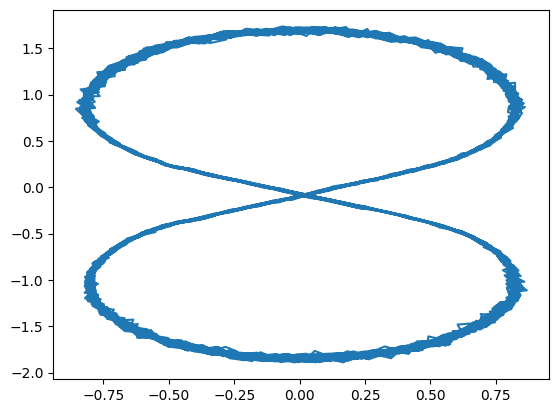

In [19]:
plt.figure
plt.plot(poseArray[:,0], poseArray[:,1])

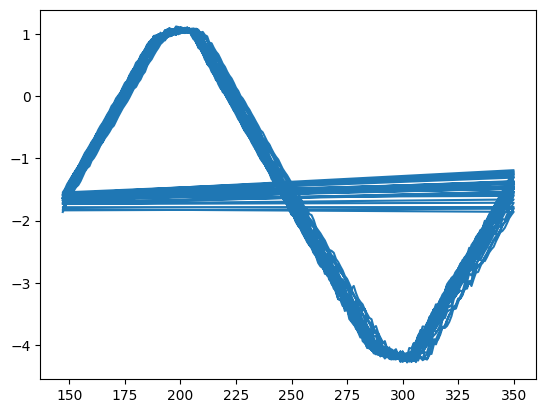

In [20]:
plt.figure
plt.plot(sampleArray, poseArray[:,2])